In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
import pandas as pd
import os
import tempfile

In [3]:
# Constants 
SKETCHY_DATABASE_PATH = "../../sketchy-database/"

**Issues:**
1. stats.csv "Category" contains names with spaces, however database directory names don't contain space but underscore.
2. testset.txt image extension is JPEG, whereas the database uses PNG

## Data preparation
### Train test split

In [4]:
class SketchyDatabase(object):
    
    DefaultSketchAugmentation = 5
    SketchAugmentations = ["tx_000000000000", "tx_000000000010", "tx_000000000110", 
                       "tx_000000001010",  "tx_000000001110",  "tx_000100000000"]

    def __init__(self, database_root, augmentation=None):
        
        self.database_root = database_root
        
        if not augmentation:
            augmentation = SketchyDatabase.SketchAugmentations[SketchyDatabase.DefaultSketchAugmentation]
            
        self.augmentation = augmentation
        self.sketch_img_path = os.path.join(self.database_root, "rendered_256x256/256x256/sketch", self.augmentation)
        self.__read_data()
    
    def __read_data(self):
        
        # read sketch data
        self.sketch_stats_df = pd.read_csv(os.path.join(self.database_root, "info/stats.csv"))
        self.sketch_invalid_ambiguous_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-ambiguous.txt"), header=None)
        self.sketch_invalid_context_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-context.txt"), header=None)
        self.sketch_invalid_error_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-error.txt"), header=None)
        self.sketch_invalid_pose_df = pd.read_csv(
                                os.path.join(self.database_root, "info/invalid-pose.txt"), header=None)
        self.sketch_testset_df = pd.read_csv(
                                os.path.join(self.database_root, "info/testset.txt"), header=None)
        
        # Add new column for convenience
        # Sketch image file name = <ImageNetID>-<SketchID>."png"
        self.sketch_stats_df["_img_file_name"] = self.sketch_stats_df["ImageNetID"] \
                                                    + "-" + self.sketch_stats_df["SketchID"].map(str)
        
        # read image data
        # ... TODO
        
    def generate_train_test_split(self, with_ambiguous=False, with_context=False, 
                                                  with_error=False, with_pose=False):
  
        sketch_df = self.sketch_stats_df #.copy(deep=True) # don't modify destructively

        # Fix "Category" name (See above: issue no. 1)
        sketch_df["Category"] = sketch_df["Category"].apply(lambda x: x.replace(" ", "_"))

        if not with_ambiguous:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_ambiguous_df[0])]
        if not with_context:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_context_df[0])]
        if not with_error:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_error_df[0])]
        if not with_pose:
            sketch_df = sketch_df.loc[~self.sketch_stats_df["_img_file_name"].isin(self.sketch_invalid_pose_df[0])]

        # databse images are in png format, but testset lists them as jpg, 
        # just blending in with the inconsistency for now
        is_test_sample = sketch_df["ImageNetID"].isin(self.sketch_testset_df[0].apply(
                                            lambda x: x.split("/")[1].split('.jpg')[0]))
        sketch_df["_split"] = "train"
        sketch_df["_split"].loc[is_test_sample] = "test"
        self.sketch_stats_df = sketch_df
        
    def get_caffeinated_dataset(self, split="train"):
        
        assert(split=="train" or split=="test")
        
        sketch_stats_filtered_df = self.sketch_stats_df[self.sketch_stats_df["_split"]==split]
        with tempfile.NamedTemporaryFile(delete=False) as f:
            for _,row in sketch_stats_filtered_df.iterrows():
                f.write(self.sketch_img_path \
                        + row["_img_file_name"] + ".png" \
                        + " " + str(row["CategoryID"]) + "\n")
        return f.name

In [5]:
sketchy_database = SketchyDatabase(SKETCHY_DATABASE_PATH)
sketchy_database.generate_train_test_split(with_ambiguous=False, with_context=False, with_error=False, with_pose=False)

## Data Exploration

In [6]:
import matplotlib.gridspec as gridspec

def vis_samples(sketch_df, sketch_img_path, grid_size=(None, None), max_tiles=100):
     

    sketch_df = sketch_df[:max_tiles].copy()
    sketch_df["_img_file_name"] = sketch_df["ImageNetID"] + "-" + sketch_df["SketchID"].map(str)
    
    n_imgs = len(sketch_df)
    n_rows, n_cols = grid_size
    
    if n_rows == None or n_cols == None:
        n_cols = int(np.ceil(np.sqrt(n_imgs)))
        n_rows = int(np.ceil(1.*n_imgs/n_cols))
    
    gs = gridspec.GridSpec(n_rows, n_cols)    
    for idx, (category, img_file) in enumerate(sketch_df[["Category", "_img_file_name"]].values):
        img_dir = os.path.join(sketch_img_path, category)
        img = plt.imread(os.path.expanduser(os.path.join(img_dir, img_file + ".png")))
        plt.subplot(gs[idx]), plt.axis("off")
        plt.imshow(img)
        plt.title(category)

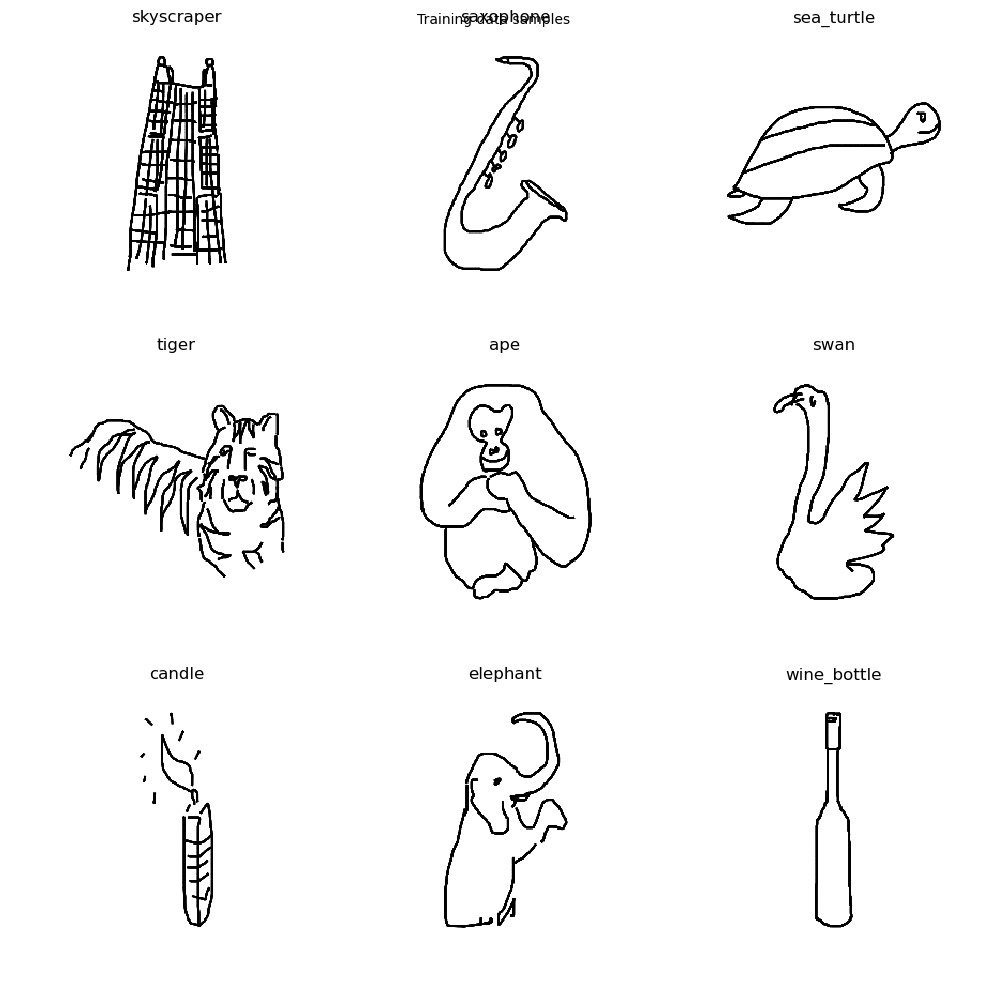

In [9]:
# np.random.seed(0)
disp_samples = 9
train_df = sketchy_database.sketch_stats_df[sketchy_database.sketch_stats_df["_split"] == "train"]

rand_locations = np.random.choice(train_df.index, disp_samples, replace=False)
vis_samples(train_df.loc[rand_locations], sketchy_database.sketch_img_path)
plt.suptitle("Training data samples")
plt.tight_layout()

In [8]:
train_img_list = sketchy_database.get_caffeinated_dataset()
test_img_list = sketchy_database.get_caffeinated_dataset(split="test")